# Comparing Different Feature Extractor Methods for Content-Based Image Retrieval

## Foundations of Information Retrieval Final Project

### Group 30: Alessandro Cortese, Gianmarco Lodi

## Loading libraries

In [ ]:
!pip install scikit-image --upgrade # Must run this line to run SIFT!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 25.1 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [1]:
import json
import h5py
import os
import pickle
import time
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

import skimage
from skimage.feature import ORB, BRIEF, corner_peaks, corner_harris
from skimage.color import rgb2gray

import keras
from keras.utils import load_img, img_to_array 
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

%matplotlib inline


## Loading the Dataset
We are using the Mapillary Street-Level Sequences (MSLS) data set. Specifically, the "data02" folder containing the images and the relevance judgments provided for the second assignment was zipped and put on a shared Google Drive folder.

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/HWs/FIR/data02.zip

In [5]:
# loading the map images
with open("/content/data02/database/database.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# loading the query images
with open("/content/data02/query/query.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])

# loading the relevance judgements
with h5py.File("data02/london_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

### Visualization of image locations

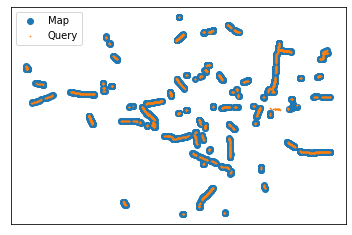

In [ ]:
plt.scatter(m_loc[:,0],m_loc[:,1], label="Map")
plt.scatter(q_loc[:,0],q_loc[:,1], label="Query", s=0.5)
#plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

## Defining classes and functions
Here we provide a FeatureExtractor class to reuse code for each configuration that we want to test. 
Moreover, functions to retrieve images based on the four different distance function and to calculate evaluation metrics are provided.

In [ ]:
class FeatureExtractor():

    def __init__(self, descriptor_extractor, cluster_algorithm, scaler=None):
        
        # Initialize the descriptor
        self.descriptor_extractor = descriptor_extractor
        # Initialize the data structure that will contain all the descriptors
        self.descriptors = None
        # Initialize the clustering model
        self.cluster_algorithm = cluster_algorithm
        # Initialize an empty data structure for the centroids:
        self.centroids = None
        # Initialize an empty data structure for the bag-of-words map:
        self.bow_map_images = None
        # Initialize the scaler -> scale feats to the same interval
        self.scaler = scaler

    def get_descriptors(self, imgs):
        for img_name in tqdm(imgs):

            # --- ORB --- #
            if type(self.descriptor_extractor) == skimage.feature.ORB:
                img = plt.imread(os.path.join('/content/data02/', img_name))
                img = rgb2gray(img)
                # Extract ORB descriptors
                self.descriptor_extractor.detect_and_extract(img)  
                # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
                descriptors_img = self.descriptor_extractor.descriptors  # descriptors (the feature vectors)

            # --- SIFT --- #
            elif type(self.descriptor_extractor) == cv2.SIFT:
                img = cv2.imread(os.path.join('/content/data02/', img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                kp, descriptors_img = self.descriptor_extractor.detectAndCompute(img, None)
            
            # --- BRIEF --- #
            elif type(self.descriptor_extractor) == skimage.feature.BRIEF:
                img = plt.imread(os.path.join('/content/data02/', img_name))
                img = rgb2gray(img)

                kp_brief = corner_peaks(corner_harris(img), min_distance=5,
                          threshold_rel=0.1)
                # Extract ORB descriptors
                self.descriptor_extractor.extract(img, kp_brief)
                kp_brief = kp_brief[self.descriptor_extractor.mask]

                descriptors_img = self.descriptor_extractor.descriptors

            else:
                raise ValueError("Unrecognized descriptor_extractor !")


            # Accumulate the computed descriptors
            if self.descriptors is None:
                self.descriptors = descriptors_img
            else:
                self.descriptors = np.vstack( (self.descriptors, descriptors_img))
        print(self.descriptors.shape)
    
    def save_descriptors(self, filename: str):
        f = open('/content/drive/MyDrive/HWs/FIR/' + filename + '.bin', 'wb')
        data = pickle.dump(self.descriptors, f)
        f.close()

    def load_descriptors(self, filename: str):
        f = open('/content/drive/MyDrive/HWs/FIR/' + filename + '.bin', 'rb')
        self.descriptors = pickle.load(f)
        f.close()
    
    def fit_cluster(self):
        clusters = self.cluster_algorithm.fit(self.descriptors)  # we use the descriptors extracted from the map (training) images before
        self.centroids = clusters.cluster_centers_

        print("Shape of the centroids matrix: ", self.centroids.shape)
        print("We computed ", self.centroids.shape[0], "centroids of lengh ", self.centroids.shape[1], " (the same of the descriptor)")
        # Rememeber: the centroids can be considered as the words that compose our documents 
        # -> in this case the basic components of the images

    def bag_of_words(self, image_descriptors):
        n_centroids = self.centroids.shape[0]  # number of centroids found with the KMeans clustering
        n_descriptors = image_descriptors.shape[0]  # number of descriptors extracted from the image
        
        # initialization of the bag of words (BoW) vector
        # Note that the BoW vector has length equal to the number of cluster centroids
        # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
        bow_vector = np.zeros(n_centroids)
        
        for i in range(n_descriptors):
            min_dist = (np.inf, -1)
            for j in range(n_centroids):
                dist_tmp = distance.euclidean(image_descriptors[i], self.centroids[j])
                if dist_tmp < min_dist[0]:
                    min_dist = (dist_tmp, j)
            bow_vector[min_dist[1]] += 1 
        return bow_vector
    
    def fit_bow(self, imgs):
        # loop over the images in the map set
        for img_name in tqdm(imgs):

            # --- ORB --- #
            if type(descriptor_extractor) == skimage.feature.ORB:
                img = plt.imread(os.path.join('/content/data02/', img_name))
                img = rgb2gray(img)
                # Extract ORB descriptors
                self.descriptor_extractor.detect_and_extract(img)  
                # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
                img_descriptors = self.descriptor_extractor.descriptors  # descriptors (the feature vectors)

            # --- SIFT --- #
            elif type(self.descriptor_extractor) == cv2.SIFT:
                img = cv2.imread(os.path.join('/content/data02/', img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                kp, img_descriptors = self.descriptor_extractor.detectAndCompute(img, None)
            
            # --- BRIEF --- #
            elif type(self.descriptor_extractor) == skimage.feature.BRIEF:
                img = plt.imread(os.path.join('/content/data02/', img_name))
                img = rgb2gray(img)

                kp_brief = corner_peaks(corner_harris(img), min_distance=5,
                          threshold_rel=0.1)
                # Extract ORB descriptors
                self.descriptor_extractor.extract(img, kp_brief)
                kp_brief = kp_brief[self.descriptor_extractor.mask]

                img_descriptors = self.descriptor_extractor.descriptors

            # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
            bow = self.bag_of_words(img_descriptors)
            # add the computed BoW vector to the set of map representations
            if self.bow_map_images is None:
                self.bow_map_images = bow
            else:
                self.bow_map_images = np.vstack( (self.bow_map_images, bow))
            
    def fit_scaler(self):
        # we get features mapped from the model
        self.scaler = self.scaler.fit(self.bow_map_images)
        self.bow_map_images = self.scaler.transform(self.bow_map_images)

In [ ]:
def retrieve_images(map_bow_vectors, query_bow, distance_metric):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  # Initialize empty data structure to keep the ranking of the images
    
    for i in range(n_map_bow_vectors):
        if distance_metric == "euclidean":
            bow_distances[i] = distance.euclidean(query_bow,map_bow_vectors[i])
        elif distance_metric == "cosine":
            bow_distances[i] = distance.cosine(query_bow,map_bow_vectors[i])
        elif distance_metric == "minkowski":
            bow_distances[i] = distance.minkowski(query_bow,map_bow_vectors[i], p = 3)
        elif distance_metric == "manhattan":
            bow_distances[i] = distance.cityblock(query_bow,map_bow_vectors[i])
        else:
            raise ValueError("Distance not recognized")
    most_similar = np.argsort(bow_distances)
    
    return most_similar

In [ ]:
def get_query_bows(q_imgs, feature_extractor):
    query_bows = None
    for i in tqdm(range(len(q_imgs))):
        query_idx = i
        # --- ORB --- #
        if type(feature_extractor.descriptor_extractor) == skimage.feature.ORB:
            img = plt.imread("/content/data02/" + q_imgs[query_idx])
            img = rgb2gray(img)
            # compute bag of words
            feature_extractor.descriptor_extractor.detect_and_extract(img)  
            query_img_descriptors = feature_extractor.descriptor_extractor.descriptors
        # --- SIFT --- #
        elif type(feature_extractor.descriptor_extractor) == cv2.SIFT:
            img = cv2.imread('/content/data02/'+ q_imgs[query_idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kp, query_img_descriptors = feature_extractor.descriptor_extractor.detectAndCompute(img, None)
        # --- BRIEF --- #
        elif type(feature_extractor.descriptor_extractor) == skimage.feature.BRIEF:
                img = plt.imread("/content/data02/" + q_imgs[query_idx])
                img = rgb2gray(img)

                kp_brief = corner_peaks(corner_harris(img), min_distance=5,
                          threshold_rel=0.1)
                # Extract ORB descriptors
                feature_extractor.descriptor_extractor.extract(img, kp_brief)
                kp_brief = kp_brief[feature_extractor.descriptor_extractor.mask]

                query_img_descriptors = feature_extractor.descriptor_extractor.descriptors
        else:
            raise ValueError("Unrecognized descriptor extractor!!!")
            
        query_bow = feature_extractor.bag_of_words(query_img_descriptors)

        # Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
        query_bow = feature_extractor.scaler.transform(query_bow.reshape(-1, 1).transpose())
        query_bow = query_bow.transpose().reshape(-1)

        if query_bows is None:
            query_bows = query_bow
        else:
            query_bows = np.vstack( (query_bows, query_bow))
    return query_bows        

In [ ]:
def top_recall_at_k(query_bows, feature_extractor, distance_metric, k):
    count = 0
    for i in tqdm(range(len(query_bows))):
        query_idx = i

        retrieved = retrieve_images(feature_extractor.bow_map_images, query_bows[query_idx], distance_metric)
        relevant = np.where(sim[query_idx, :] == 1)[0]
        if len(set(retrieved[:k]).intersection(relevant)) > 0:
            count += 1
    return count / len(q_imgs)

def precision_at_k(relevant, retrieved, k):
    return len(set(retrieved[:k]).intersection(relevant)) / len(retrieved[:k])

def average_precision(relevant, retrieved):
    numerator = 0
    for i in range(len(retrieved)):
        if retrieved[i] in relevant:
            numerator += precision_at_k(relevant, retrieved, i+1)
    if len(relevant) == 0:
        return 1
    else:
        return numerator/len(relevant)

def mean_average_precision(query_bows, feature_extractor, distance_metric):
    count = 0
    for i in tqdm(range(len(q_imgs))):
        query_idx = i
    
        retrieved_images = retrieve_images(feature_extractor.bow_map_images, query_bows[query_idx], distance_metric)
        relevant_images = np.where(sim[query_idx, :] == 1)[0]
        avg_prec = average_precision(relevant_images, retrieved_images)

        count += avg_prec

    mean_avg_prec = count / len(q_imgs)
    return mean_avg_prec

# ORB feature extractor 

## Keypoints = 50

In [ ]:
descriptor_extractor = ORB(n_keypoints=50)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
orb50 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
orb50.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [14:06<00:00,  3.89it/s]

(164550, 256)


In [ ]:
orb50.load_descriptors("orb50-descriptors")

In [ ]:
orb50.fit_cluster()

Initialization complete
Iteration 0, inertia 15292158.0
Iteration 1, inertia 9062737.252333147
Iteration 2, inertia 8979530.748524077
Iteration 3, inertia 8951069.308051396
Iteration 4, inertia 8935752.973455954
Iteration 5, inertia 8925722.346428473
Iteration 6, inertia 8918638.706119142
Iteration 7, inertia 8913562.014583148
Iteration 8, inertia 8909771.871142704
Iteration 9, inertia 8906812.11438904
Iteration 10, inertia 8904549.814853424
Iteration 11, inertia 8902758.920239296
Iteration 12, inertia 8901316.764928047
Iteration 13, inertia 8900066.955280414
Iteration 14, inertia 8899014.277129762
Iteration 15, inertia 8898137.429965433
Iteration 16, inertia 8897370.499304798
Iteration 17, inertia 8896669.109543733
Iteration 18, inertia 8896011.01875891
Iteration 19, inertia 8895445.907340514
Iteration 20, inertia 8894927.456120536
Iteration 21, inertia 8894444.122932155
Iteration 22, inertia 8893975.833047096
Iteration 23, inertia 8893561.587753836
Iteration 24, inertia 8893179.91798

In [ ]:
orb50.centroids.shape

(32, 256)

In [ ]:
orb50.fit_bow(m_imgs)

100%|██████████| 3291/3291 [14:41<00:00,  3.73it/s]


In [ ]:
orb50.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, orb50)
query_bows.shape

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, orb50, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, orb50, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, orb50, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, orb50, dist_metric))


--- euclidean distance ---



100%|██████████| 2692/2692 [01:17<00:00, 34.92it/s]


Top Recall@1 : 0.008172362555720654


100%|██████████| 2692/2692 [01:13<00:00, 36.78it/s]


Top Recall@5 : 0.018945022288261514


100%|██████████| 2692/2692 [01:15<00:00, 35.70it/s]


Top Recall@10 : 0.03714710252600297


100%|██████████| 2692/2692 [01:50<00:00, 24.31it/s]


Mean average precision :  0.023743969582896363
--- cosine distance ---



100%|██████████| 2692/2692 [05:21<00:00,  8.37it/s]


Top Recall@1 : 0.008172362555720654


100%|██████████| 2692/2692 [05:23<00:00,  8.31it/s]


Top Recall@5 : 0.021173848439821695


100%|██████████| 2692/2692 [05:21<00:00,  8.38it/s]


Top Recall@10 : 0.037518573551263


100%|██████████| 2692/2692 [05:56<00:00,  7.56it/s]


Mean average precision :  0.024898615281650174
--- minkowski distance ---



100%|██████████| 2692/2692 [02:59<00:00, 14.98it/s]


Top Recall@1 : 0.007429420505200594


100%|██████████| 2692/2692 [02:59<00:00, 15.01it/s]


Top Recall@5 : 0.020430906389301635


100%|██████████| 2692/2692 [02:59<00:00, 14.96it/s]


Top Recall@10 : 0.034918276374442794


100%|██████████| 2692/2692 [03:32<00:00, 12.65it/s]


Mean average precision :  0.02361895963812752
--- manhattan distance ---



100%|██████████| 2692/2692 [00:44<00:00, 60.32it/s]


Top Recall@1 : 0.008915304606240713


100%|██████████| 2692/2692 [00:42<00:00, 63.62it/s]


Top Recall@5 : 0.021916790490341752


100%|██████████| 2692/2692 [00:42<00:00, 63.61it/s]


Top Recall@10 : 0.03677563150074294


100%|██████████| 2692/2692 [01:19<00:00, 33.90it/s]

Mean average precision :  0.024182836872337122


## Keypoints = 100

In [ ]:
descriptor_extractor = ORB(n_keypoints=100)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
orb100 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
orb100.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [14:06<00:00,  3.89it/s]

(329060, 256)


In [ ]:
orb100.save_descriptors("orb100-descriptors")
orb100.load_descriptors("orb100-descriptors")

In [ ]:
orb100.fit_cluster()

Initialization complete
Iteration 0, inertia 30554096.0
Iteration 1, inertia 18157718.798893742
Iteration 2, inertia 17986297.39085175
Iteration 3, inertia 17932863.77665496
Iteration 4, inertia 17904809.857413363
Iteration 5, inertia 17886645.22359606
Iteration 6, inertia 17873416.679860674
Iteration 7, inertia 17863186.993497737
Iteration 8, inertia 17855135.744725123
Iteration 9, inertia 17848759.594551176
Iteration 10, inertia 17843623.38843297
Iteration 11, inertia 17839511.167634323
Iteration 12, inertia 17836058.80912389
Iteration 13, inertia 17833105.871278524
Iteration 14, inertia 17830627.690802738
Iteration 15, inertia 17828478.584630735
Iteration 16, inertia 17826599.79157854
Iteration 17, inertia 17824986.3032829
Iteration 18, inertia 17823542.641792174
Iteration 19, inertia 17822253.881634146
Iteration 20, inertia 17821083.131974496
Iteration 21, inertia 17820032.562801093
Iteration 22, inertia 17819131.13202645
Iteration 23, inertia 17818344.1543502
Iteration 24, inertia

In [ ]:
orb100.centroids.shape

(32, 256)

In [ ]:
orb100.fit_bow(m_imgs)

100%|██████████| 3291/3291 [15:22<00:00,  3.57it/s]


In [ ]:
orb100.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, orb100)
query_bows.shape

100%|██████████| 2692/2692 [12:16<00:00,  3.66it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, orb100, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, orb100, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, orb100, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, orb100, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:18<00:00, 34.46it/s]


Top Recall@1 : 0.009286775631500743


100%|██████████| 2692/2692 [01:16<00:00, 35.11it/s]


Top Recall@5 : 0.024145616641901933


100%|██████████| 2692/2692 [01:17<00:00, 34.70it/s]


Top Recall@10 : 0.03974739970282318


100%|██████████| 2692/2692 [01:56<00:00, 23.21it/s]


Mean average precision :  0.02448542278054982
--- cosine distance ---



100%|██████████| 2692/2692 [05:39<00:00,  7.93it/s]


Top Recall@1 : 0.008543833580980683


100%|██████████| 2692/2692 [05:37<00:00,  7.97it/s]


Top Recall@5 : 0.02711738484398217


100%|██████████| 2692/2692 [05:38<00:00,  7.96it/s]


Top Recall@10 : 0.043833580980683504


100%|██████████| 2692/2692 [06:14<00:00,  7.18it/s]


Mean average precision :  0.025648564917739668
--- minkowski distance ---



100%|██████████| 2692/2692 [03:05<00:00, 14.54it/s]


Top Recall@1 : 0.007429420505200594


100%|██████████| 2692/2692 [03:06<00:00, 14.40it/s]


Top Recall@5 : 0.021916790490341752


100%|██████████| 2692/2692 [03:06<00:00, 14.41it/s]


Top Recall@10 : 0.036404160475482915


100%|██████████| 2692/2692 [03:39<00:00, 12.25it/s]


Mean average precision :  0.024187365579003816
--- manhattan distance ---



100%|██████████| 2692/2692 [00:43<00:00, 62.19it/s]


Top Recall@1 : 0.007800891530460624


100%|██████████| 2692/2692 [00:45<00:00, 59.26it/s]


Top Recall@5 : 0.02637444279346211


100%|██████████| 2692/2692 [00:45<00:00, 59.27it/s]


Top Recall@10 : 0.041976225854383355


100%|██████████| 2692/2692 [01:23<00:00, 32.20it/s]

Mean average precision :  0.024356679777090048


## Keypoints = 200

In [ ]:
descriptor_extractor = ORB(n_keypoints=200)


kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
orb200 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
orb200.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [14:38<00:00,  3.75it/s]

(657749, 256)


In [ ]:
orb200.save_descriptors("orb200-descriptors")
orb200.load_descriptors("orb200-descriptors")

In [ ]:
orb200.fit_cluster()

Initialization complete
Iteration 0, inertia 61561038.0
Iteration 1, inertia 36394334.693140134
Iteration 2, inertia 36058436.97227817
Iteration 3, inertia 35943692.45597719
Iteration 4, inertia 35884286.4876989
Iteration 5, inertia 35847528.156196326
Iteration 6, inertia 35823048.232391044
Iteration 7, inertia 35805698.6952938
Iteration 8, inertia 35792529.702116996
Iteration 9, inertia 35782147.34401335
Iteration 10, inertia 35773799.737393305
Iteration 11, inertia 35766742.05856611
Iteration 12, inertia 35760623.09803808
Iteration 13, inertia 35755116.02105326
Iteration 14, inertia 35750164.77966416
Iteration 15, inertia 35745711.43625436
Iteration 16, inertia 35741580.829591155
Iteration 17, inertia 35737700.31282151
Iteration 18, inertia 35734224.329407856
Iteration 19, inertia 35731129.69322872
Iteration 20, inertia 35728360.950103685
Iteration 21, inertia 35725940.204966515
Iteration 22, inertia 35723730.42147964
Iteration 23, inertia 35721730.00907354
Iteration 24, inertia 3571

In [ ]:
orb200.centroids.shape

(32, 256)

In [ ]:
orb200.fit_bow(m_imgs)

100%|██████████| 3291/3291 [17:18<00:00,  3.17it/s]


In [ ]:
orb200.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, orb200)
query_bows.shape

100%|██████████| 2692/2692 [13:49<00:00,  3.24it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, orb200, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, orb200, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, orb200, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, orb200, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:17<00:00, 34.71it/s]


Top Recall@1 : 0.010029717682020803


100%|██████████| 2692/2692 [01:18<00:00, 34.41it/s]


Top Recall@5 : 0.020802377414561663


100%|██████████| 2692/2692 [01:16<00:00, 35.35it/s]


Top Recall@10 : 0.03974739970282318


100%|██████████| 2692/2692 [01:54<00:00, 23.60it/s]


Mean average precision :  0.025817982293632698
--- cosine distance ---



100%|██████████| 2692/2692 [05:37<00:00,  7.98it/s]


Top Recall@1 : 0.010029717682020803


100%|██████████| 2692/2692 [05:35<00:00,  8.03it/s]


Top Recall@5 : 0.029346210995542348


100%|██████████| 2692/2692 [05:35<00:00,  8.02it/s]


Top Recall@10 : 0.04940564635958395


100%|██████████| 2692/2692 [06:13<00:00,  7.20it/s]


Mean average precision :  0.027894164900551438
--- minkowski distance ---



100%|██████████| 2692/2692 [03:07<00:00, 14.35it/s]


Top Recall@1 : 0.008915304606240713


100%|██████████| 2692/2692 [03:05<00:00, 14.52it/s]


Top Recall@5 : 0.021916790490341752


100%|██████████| 2692/2692 [03:07<00:00, 14.36it/s]


Top Recall@10 : 0.04234769687964339


100%|██████████| 2692/2692 [03:42<00:00, 12.12it/s]


Mean average precision :  0.0253218735884407
--- manhattan distance ---



100%|██████████| 2692/2692 [00:45<00:00, 59.05it/s]


Top Recall@1 : 0.008915304606240713


100%|██████████| 2692/2692 [00:43<00:00, 62.32it/s]


Top Recall@5 : 0.0237741456166419


100%|██████████| 2692/2692 [00:45<00:00, 59.17it/s]


Top Recall@10 : 0.041604754829123326


100%|██████████| 2692/2692 [01:26<00:00, 31.28it/s]

Mean average precision :  0.025862350131684607


# SIFT feature extractor

## Number of features = 50

In [ ]:
descriptor_extractor = cv2.SIFT_create(nfeatures=50)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
sift50 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
sift50.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [02:31<00:00, 21.71it/s]

(165351, 128)


In [ ]:
#sift50.save_descriptors("sift50-descriptors")
sift50.load_descriptors("sift50-descriptors")

In [ ]:
sift50.fit_cluster()

Initialization complete
Iteration 0, inertia 22125576192.0
Iteration 1, inertia 14729987072.0
Iteration 2, inertia 14425145344.0
Iteration 3, inertia 14282200064.0
Iteration 4, inertia 14196959232.0
Iteration 5, inertia 14141300736.0
Iteration 6, inertia 14098400256.0
Iteration 7, inertia 14063226880.0
Iteration 8, inertia 14037794816.0
Iteration 9, inertia 14021242880.0
Iteration 10, inertia 14010048512.0
Iteration 11, inertia 14001913856.0
Iteration 12, inertia 13995878400.0
Iteration 13, inertia 13991450624.0
Iteration 14, inertia 13988221952.0
Iteration 15, inertia 13985434624.0
Iteration 16, inertia 13982899200.0
Iteration 17, inertia 13980777472.0
Iteration 18, inertia 13978726400.0
Iteration 19, inertia 13976939520.0
Iteration 20, inertia 13974990848.0
Iteration 21, inertia 13973120000.0
Iteration 22, inertia 13971025920.0
Iteration 23, inertia 13968978944.0
Iteration 24, inertia 13966889984.0
Iteration 25, inertia 13964705792.0
Iteration 26, inertia 13962900480.0
Iteration 27, 

In [ ]:
sift50.centroids.shape

(32, 128)

In [ ]:
sift50.fit_bow(m_imgs)

100%|██████████| 3291/3291 [02:53<00:00, 18.92it/s]


In [ ]:
sift50.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, sift50)
query_bows.shape

100%|██████████| 2692/2692 [02:10<00:00, 20.61it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, sift50, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, sift50, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, sift50, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, sift50, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:13<00:00, 36.39it/s]


Top Recall@1 : 0.005572065378900446


100%|██████████| 2692/2692 [01:14<00:00, 36.02it/s]


Top Recall@5 : 0.03268945022288262


100%|██████████| 2692/2692 [01:12<00:00, 37.04it/s]


Top Recall@10 : 0.05646359583952452


100%|██████████| 2692/2692 [01:51<00:00, 24.16it/s]


Mean average precision :  0.027349257659839147
--- cosine distance ---



100%|██████████| 2692/2692 [05:27<00:00,  8.23it/s]


Top Recall@1 : 0.008172362555720654


100%|██████████| 2692/2692 [05:23<00:00,  8.33it/s]


Top Recall@5 : 0.03937592867756315


100%|██████████| 2692/2692 [05:24<00:00,  8.30it/s]


Top Recall@10 : 0.06835066864784546


100%|██████████| 2692/2692 [05:57<00:00,  7.53it/s]


Mean average precision :  0.030057112577575276
--- minkowski distance ---



100%|██████████| 2692/2692 [02:59<00:00, 14.96it/s]


Top Recall@1 : 0.007429420505200594


100%|██████████| 2692/2692 [03:01<00:00, 14.79it/s]


Top Recall@5 : 0.03417533432392273


100%|██████████| 2692/2692 [02:58<00:00, 15.05it/s]


Top Recall@10 : 0.05609212481426449


100%|██████████| 2692/2692 [03:38<00:00, 12.30it/s]


Mean average precision :  0.02697948772804857
--- manhattan distance ---



100%|██████████| 2692/2692 [00:41<00:00, 64.24it/s]


Top Recall@1 : 0.008172362555720654


100%|██████████| 2692/2692 [00:43<00:00, 61.60it/s]


Top Recall@5 : 0.03268945022288262


100%|██████████| 2692/2692 [00:42<00:00, 63.82it/s]


Top Recall@10 : 0.060549777117384844


100%|██████████| 2692/2692 [01:18<00:00, 34.32it/s]

Mean average precision :  0.027823364335261933


## Number of features = 100

In [ ]:
descriptor_extractor = cv2.SIFT_create(nfeatures=100)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()


In [ ]:
sift100 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
sift100.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [03:41<00:00, 14.83it/s]

(329706, 128)


In [ ]:
sift100.save_descriptors("sift100-descriptors")
sift100.load_descriptors("sift100-descriptors")

In [ ]:
sift100.fit_cluster()

Initialization complete
Iteration 0, inertia 45639909376.0
Iteration 1, inertia 30088687616.0
Iteration 2, inertia 29501986816.0
Iteration 3, inertia 29262934016.0
Iteration 4, inertia 29120708608.0
Iteration 5, inertia 29029965824.0
Iteration 6, inertia 28972681216.0
Iteration 7, inertia 28934768640.0
Iteration 8, inertia 28909068288.0
Iteration 9, inertia 28889608192.0
Iteration 10, inertia 28872851456.0
Iteration 11, inertia 28857333760.0
Iteration 12, inertia 28843618304.0
Iteration 13, inertia 28830760960.0
Iteration 14, inertia 28819468288.0
Iteration 15, inertia 28809240576.0
Iteration 16, inertia 28799991808.0
Iteration 17, inertia 28792639488.0
Iteration 18, inertia 28787134464.0
Iteration 19, inertia 28782166016.0
Iteration 20, inertia 28778487808.0
Iteration 21, inertia 28775112704.0
Iteration 22, inertia 28771823616.0
Iteration 23, inertia 28769214464.0
Iteration 24, inertia 28766461952.0
Iteration 25, inertia 28763676672.0
Iteration 26, inertia 28761067520.0
Iteration 27, 

In [ ]:
sift100.centroids.shape

(32, 128)

In [ ]:
sift100.fit_bow(m_imgs)

100%|██████████| 3291/3291 [03:37<00:00, 15.14it/s]


In [ ]:
sift100.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, sift100)
query_bows.shape

100%|██████████| 2692/2692 [02:51<00:00, 15.69it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, sift100, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, sift100, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, sift100, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, sift100, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:14<00:00, 35.99it/s]


Top Recall@1 : 0.015230312035661218


100%|██████████| 2692/2692 [01:12<00:00, 37.01it/s]


Top Recall@5 : 0.05312035661218425


100%|██████████| 2692/2692 [01:14<00:00, 36.05it/s]


Top Recall@10 : 0.08320950965824665


100%|██████████| 2692/2692 [01:51<00:00, 24.22it/s]


Mean average precision :  0.03180915491790433
--- cosine distance ---



100%|██████████| 2692/2692 [05:28<00:00,  8.19it/s]


Top Recall@1 : 0.017830609212481426


100%|██████████| 2692/2692 [05:31<00:00,  8.12it/s]


Top Recall@5 : 0.05646359583952452


100%|██████████| 2692/2692 [05:28<00:00,  8.20it/s]


Top Recall@10 : 0.08692421991084695


100%|██████████| 2692/2692 [06:05<00:00,  7.37it/s]


Mean average precision :  0.03422674835884355
--- minkowski distance ---



100%|██████████| 2692/2692 [03:02<00:00, 14.71it/s]


Top Recall@1 : 0.01337295690936107


100%|██████████| 2692/2692 [03:02<00:00, 14.78it/s]


Top Recall@5 : 0.04903417533432392


100%|██████████| 2692/2692 [03:04<00:00, 14.62it/s]


Top Recall@10 : 0.08283803863298662


100%|██████████| 2692/2692 [03:39<00:00, 12.28it/s]


Mean average precision :  0.030763213879532004
--- manhattan distance ---



100%|██████████| 2692/2692 [00:42<00:00, 63.20it/s]


Top Recall@1 : 0.01448736998514116


100%|██████████| 2692/2692 [00:44<00:00, 59.97it/s]


Top Recall@5 : 0.048291233283803865


100%|██████████| 2692/2692 [00:42<00:00, 63.03it/s]


Top Recall@10 : 0.08023774145616643


100%|██████████| 2692/2692 [01:21<00:00, 33.10it/s]

Mean average precision :  0.031857839151239194


## Number of features = 200

In [ ]:
descriptor_extractor = cv2.SIFT_create(nfeatures=200)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
sift200 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
sift200.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [04:57<00:00, 11.07it/s]

(656535, 128)


In [ ]:
sift200.save_descriptors("sift200-descriptors")
sift200.load_descriptors("sift200-descriptors")

In [ ]:
sift200.fit_cluster()

Initialization complete
Iteration 0, inertia 91999068160.0
Iteration 1, inertia 61217243136.0
Iteration 2, inertia 60122652672.0
Iteration 3, inertia 59753914368.0
Iteration 4, inertia 59545796608.0
Iteration 5, inertia 59401416704.0
Iteration 6, inertia 59294023680.0
Iteration 7, inertia 59212529664.0
Iteration 8, inertia 59143888896.0
Iteration 9, inertia 59080237056.0
Iteration 10, inertia 59023867904.0
Iteration 11, inertia 58978430976.0
Iteration 12, inertia 58944819200.0
Iteration 13, inertia 58919227392.0
Iteration 14, inertia 58898927616.0
Iteration 15, inertia 58883899392.0
Iteration 16, inertia 58871152640.0
Iteration 17, inertia 58860167168.0
Iteration 18, inertia 58850975744.0
Iteration 19, inertia 58843545600.0
Iteration 20, inertia 58837540864.0
Iteration 21, inertia 58832363520.0
Iteration 22, inertia 58827784192.0
Iteration 23, inertia 58824060928.0
Iteration 24, inertia 58821050368.0
Iteration 25, inertia 58817626112.0
Iteration 26, inertia 58814529536.0
Iteration 27, 

In [ ]:
sift200.centroids.shape

(32, 128)

In [ ]:
sift200.fit_bow(m_imgs)

100%|██████████| 3291/3291 [05:00<00:00, 10.96it/s]


In [ ]:
sift200.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, sift200)
query_bows.shape

100%|██████████| 2692/2692 [04:02<00:00, 11.10it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, sift200, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, sift200, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, sift200, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, sift200, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:11<00:00, 37.61it/s]


Top Recall@1 : 0.019687964338781574


100%|██████████| 2692/2692 [01:13<00:00, 36.76it/s]


Top Recall@5 : 0.060549777117384844


100%|██████████| 2692/2692 [01:13<00:00, 36.58it/s]


Top Recall@10 : 0.1036404160475483


100%|██████████| 2692/2692 [01:48<00:00, 24.76it/s]


Mean average precision :  0.03553225627204527
--- cosine distance ---



100%|██████████| 2692/2692 [05:22<00:00,  8.34it/s]


Top Recall@1 : 0.022659732540861812


100%|██████████| 2692/2692 [05:20<00:00,  8.41it/s]


Top Recall@5 : 0.07429420505200594


100%|██████████| 2692/2692 [05:24<00:00,  8.30it/s]


Top Recall@10 : 0.11218424962852898


100%|██████████| 2692/2692 [05:56<00:00,  7.55it/s]


Mean average precision :  0.039006088445070336
--- minkowski distance ---



100%|██████████| 2692/2692 [02:58<00:00, 15.05it/s]


Top Recall@1 : 0.015973254086181277


100%|██████████| 2692/2692 [03:01<00:00, 14.85it/s]


Top Recall@5 : 0.06092124814264487


100%|██████████| 2692/2692 [03:01<00:00, 14.80it/s]


Top Recall@10 : 0.09955423476968796


100%|██████████| 2692/2692 [03:35<00:00, 12.51it/s]


Mean average precision :  0.03428390035759776
--- manhattan distance ---



100%|██████████| 2692/2692 [00:41<00:00, 64.13it/s]


Top Recall@1 : 0.016716196136701337


100%|██████████| 2692/2692 [00:43<00:00, 61.51it/s]


Top Recall@5 : 0.06315007429420505


100%|██████████| 2692/2692 [00:41<00:00, 64.28it/s]


Top Recall@10 : 0.10326894502228826


100%|██████████| 2692/2692 [01:19<00:00, 33.97it/s]

Mean average precision :  0.036225958233760375


# BRIEF feature extractor

## Descriptor size = 128

In [ ]:
descriptor_extractor = BRIEF(descriptor_size = 128)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
brief128 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
brief128.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [01:29<00:00, 36.94it/s]

(80524, 128)


In [ ]:
brief128.save_descriptors("brief128-descriptors")
brief128.load_descriptors("brief128-descriptors")

In [ ]:
brief128.descriptors.shape

(80524, 128)

In [ ]:
brief128.fit_cluster()

Initialization complete
Iteration 0, inertia 2789163.0
Iteration 1, inertia 1794400.9182845387
Iteration 2, inertia 1772180.6365780234
Iteration 3, inertia 1765031.3359199553
Iteration 4, inertia 1761152.6384218214
Iteration 5, inertia 1758388.9177071776
Iteration 6, inertia 1756252.355140404
Iteration 7, inertia 1754517.4068162465
Iteration 8, inertia 1753022.9273115166
Iteration 9, inertia 1751795.3266574808
Iteration 10, inertia 1750770.3367043533
Iteration 11, inertia 1749963.2108560153
Iteration 12, inertia 1749297.375211983
Iteration 13, inertia 1748746.2776161234
Iteration 14, inertia 1748250.9863573154
Iteration 15, inertia 1747819.7681314745
Iteration 16, inertia 1747469.3160351138
Iteration 17, inertia 1747167.4329469155
Iteration 18, inertia 1746901.3950221618
Iteration 19, inertia 1746673.924369077
Iteration 20, inertia 1746477.0034801117
Iteration 21, inertia 1746292.7032431152
Iteration 22, inertia 1746148.1081271137
Iteration 23, inertia 1746031.093794097
Iteration 24, i

In [ ]:
brief128.centroids.shape

(32, 128)

In [ ]:
brief128.fit_bow(m_imgs)

100%|██████████| 3291/3291 [01:55<00:00, 28.56it/s]


In [ ]:
brief128.fit_scaler()

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, brief128)
query_bows.shape

100%|██████████| 2692/2692 [01:34<00:00, 28.57it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, brief128, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, brief128, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, brief128, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, brief128, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:19<00:00, 33.72it/s]


Top Recall@1 : 0.010772659732540862


100%|██████████| 2692/2692 [01:19<00:00, 33.88it/s]


Top Recall@5 : 0.029346210995542348


100%|██████████| 2692/2692 [01:16<00:00, 35.16it/s]


Top Recall@10 : 0.04940564635958395


100%|██████████| 2692/2692 [01:58<00:00, 22.71it/s]


Mean average precision :  0.02608553238911797
--- cosine distance ---



100%|██████████| 2692/2692 [05:49<00:00,  7.70it/s]


Top Recall@1 : 0.008543833580980683


100%|██████████| 2692/2692 [05:49<00:00,  7.70it/s]


Top Recall@5 : 0.03677563150074294


100%|██████████| 2692/2692 [05:50<00:00,  7.69it/s]


Top Recall@10 : 0.05943536404160475


100%|██████████| 2692/2692 [06:16<00:00,  7.16it/s]


Mean average precision :  0.027700827864592534
--- minkowski distance ---



100%|██████████| 2692/2692 [03:04<00:00, 14.59it/s]


Top Recall@1 : 0.007800891530460624


100%|██████████| 2692/2692 [03:06<00:00, 14.40it/s]


Top Recall@5 : 0.0274888558692422


100%|██████████| 2692/2692 [03:05<00:00, 14.53it/s]


Top Recall@10 : 0.048291233283803865


100%|██████████| 2692/2692 [03:44<00:00, 12.00it/s]


Mean average precision :  0.025574707318576785
--- manhattan distance ---



100%|██████████| 2692/2692 [00:46<00:00, 57.59it/s]


Top Recall@1 : 0.005572065378900446


100%|██████████| 2692/2692 [00:46<00:00, 58.46it/s]


Top Recall@5 : 0.023031203566121844


100%|██████████| 2692/2692 [00:47<00:00, 56.16it/s]


Top Recall@10 : 0.045319465081723624


100%|██████████| 2692/2692 [01:23<00:00, 32.07it/s]

Mean average precision :  0.0242904656531709


## Descriptor size = 256

In [ ]:
descriptor_extractor = BRIEF(descriptor_size = 256)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
brief256 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
brief256.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [01:34<00:00, 34.81it/s]

(80524, 256)


In [ ]:
brief256.save_descriptors("brief256-descriptors")
brief256.load_descriptors("brief256-descriptors")

In [ ]:
brief256.descriptors.shape

(80524, 256)

In [ ]:
brief256.fit_cluster()

Initialization complete
Iteration 0, inertia 5967087.0
Iteration 1, inertia 3694664.65898047
Iteration 2, inertia 3649981.52839163
Iteration 3, inertia 3635490.780809527
Iteration 4, inertia 3628195.4569018576
Iteration 5, inertia 3624043.095676887
Iteration 6, inertia 3621407.7060291725
Iteration 7, inertia 3619401.370585592
Iteration 8, inertia 3617748.8612259803
Iteration 9, inertia 3616356.149114891
Iteration 10, inertia 3615043.3428636235
Iteration 11, inertia 3613714.739084955
Iteration 12, inertia 3612499.1318302657
Iteration 13, inertia 3611542.217127214
Iteration 14, inertia 3610648.9047089424
Iteration 15, inertia 3609857.988836286
Iteration 16, inertia 3609177.4283986283
Iteration 17, inertia 3608588.76230195
Iteration 18, inertia 3608094.274731012
Iteration 19, inertia 3607696.16352123
Iteration 20, inertia 3607353.9765626136
Iteration 21, inertia 3607065.0990859075
Iteration 22, inertia 3606825.5854019085
Iteration 23, inertia 3606598.3494377467
Iteration 24, inertia 36063

In [ ]:
brief256.centroids.shape

(32, 256)

In [ ]:
brief256.fit_bow(m_imgs)

100%|██████████| 3291/3291 [01:51<00:00, 29.51it/s]


In [ ]:
brief256.fit_scaler()

In [ ]:
brief256.bow_map_images.shape

(3291, 32)

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, brief256)
query_bows.shape

100%|██████████| 2692/2692 [01:35<00:00, 28.19it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, brief256, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, brief256, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, brief256, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, brief256, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:12<00:00, 37.06it/s]


Top Recall@1 : 0.009286775631500743


100%|██████████| 2692/2692 [01:12<00:00, 37.14it/s]


Top Recall@5 : 0.033060921248142645


100%|██████████| 2692/2692 [01:14<00:00, 36.10it/s]


Top Recall@10 : 0.0549777117384844


100%|██████████| 2692/2692 [01:48<00:00, 24.78it/s]


Mean average precision :  0.02597051279343778
--- cosine distance ---



100%|██████████| 2692/2692 [05:25<00:00,  8.28it/s]


Top Recall@1 : 0.01263001485884101


100%|██████████| 2692/2692 [05:23<00:00,  8.33it/s]


Top Recall@5 : 0.036404160475482915


100%|██████████| 2692/2692 [05:28<00:00,  8.20it/s]


Top Recall@10 : 0.05906389301634472


100%|██████████| 2692/2692 [06:01<00:00,  7.45it/s]


Mean average precision :  0.027995183761953445
--- minkowski distance ---



100%|██████████| 2692/2692 [02:58<00:00, 15.06it/s]


Top Recall@1 : 0.010029717682020803


100%|██████████| 2692/2692 [03:05<00:00, 14.53it/s]


Top Recall@5 : 0.03194650817236255


100%|██████████| 2692/2692 [03:07<00:00, 14.37it/s]


Top Recall@10 : 0.05386329866270431


100%|██████████| 2692/2692 [03:44<00:00, 12.01it/s]


Mean average precision :  0.02601775161181756
--- manhattan distance ---



100%|██████████| 2692/2692 [00:44<00:00, 60.21it/s]


Top Recall@1 : 0.005943536404160475


100%|██████████| 2692/2692 [00:42<00:00, 63.23it/s]


Top Recall@5 : 0.02451708766716196


100%|██████████| 2692/2692 [00:47<00:00, 56.93it/s]


Top Recall@10 : 0.04606240713224369


100%|██████████| 2692/2692 [01:23<00:00, 32.07it/s]

Mean average precision :  0.024826166233459963


## Descriptor size = 512

In [ ]:
descriptor_extractor = BRIEF(descriptor_size = 512)

kmeans = KMeans(n_clusters=32, random_state=30, n_init=5, max_iter = 500, verbose=1)

stdscaler = StandardScaler()

In [ ]:
brief512 = FeatureExtractor(descriptor_extractor=descriptor_extractor,
                         cluster_algorithm = kmeans,
                         scaler = stdscaler)

In [ ]:
brief512.get_descriptors(m_imgs)

100%|██████████| 3291/3291 [01:51<00:00, 29.40it/s]

(80524, 512)


In [ ]:
brief512.save_descriptors("brief512-descriptors")
brief512.load_descriptors("brief512-descriptors")

In [ ]:
brief512.descriptors.shape

(80524, 512)

In [ ]:
brief512.fit_cluster()

Initialization complete
Iteration 0, inertia 12228892.0
Iteration 1, inertia 7544764.402879394
Iteration 2, inertia 7450599.206312586
Iteration 3, inertia 7416775.011920868
Iteration 4, inertia 7401660.857168765
Iteration 5, inertia 7393247.915896238
Iteration 6, inertia 7387509.114624173
Iteration 7, inertia 7383179.170060679
Iteration 8, inertia 7379652.029297711
Iteration 9, inertia 7376685.6136127515
Iteration 10, inertia 7374221.199723927
Iteration 11, inertia 7371978.098385759
Iteration 12, inertia 7370005.146512352
Iteration 13, inertia 7368300.576092701
Iteration 14, inertia 7366884.448969621
Iteration 15, inertia 7365592.811602707
Iteration 16, inertia 7364398.198603433
Iteration 17, inertia 7363323.25877497
Iteration 18, inertia 7362294.01789307
Iteration 19, inertia 7361242.287169449
Iteration 20, inertia 7360274.071073801
Iteration 21, inertia 7359377.325384587
Iteration 22, inertia 7358545.873602848
Iteration 23, inertia 7357814.858547147
Iteration 24, inertia 7357145.6327

In [ ]:
brief512.centroids.shape

(32, 512)

In [ ]:
brief512.fit_bow(m_imgs)

100%|██████████| 3291/3291 [02:00<00:00, 27.36it/s]


In [ ]:
brief512.fit_scaler()

In [ ]:
brief512.bow_map_images.shape

(3291, 32)

### Retrieving images

In [ ]:
query_bows = get_query_bows(q_imgs, brief512)
query_bows.shape

100%|██████████| 2692/2692 [01:35<00:00, 28.06it/s]


(2692, 32)

### Evaluation

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, brief512, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, brief512, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, brief512, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, brief512, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [01:15<00:00, 35.56it/s]


Top Recall@1 : 0.007057949479940565


100%|██████████| 2692/2692 [01:20<00:00, 33.33it/s]


Top Recall@5 : 0.030089153046062408


100%|██████████| 2692/2692 [01:15<00:00, 35.53it/s]


Top Recall@10 : 0.045319465081723624


100%|██████████| 2692/2692 [01:56<00:00, 23.14it/s]


Mean average precision :  0.025348161416348887
--- cosine distance ---



100%|██████████| 2692/2692 [05:47<00:00,  7.74it/s]


Top Recall@1 : 0.008172362555720654


100%|██████████| 2692/2692 [05:44<00:00,  7.82it/s]


Top Recall@5 : 0.0338038632986627


100%|██████████| 2692/2692 [05:38<00:00,  7.94it/s]


Top Recall@10 : 0.05832095096582467


100%|██████████| 2692/2692 [06:17<00:00,  7.13it/s]


Mean average precision :  0.027616911497075163
--- minkowski distance ---



100%|██████████| 2692/2692 [03:06<00:00, 14.45it/s]


Top Recall@1 : 0.007800891530460624


100%|██████████| 2692/2692 [03:03<00:00, 14.68it/s]


Top Recall@5 : 0.029717682020802376


100%|██████████| 2692/2692 [03:03<00:00, 14.66it/s]


Top Recall@10 : 0.045319465081723624


100%|██████████| 2692/2692 [03:42<00:00, 12.12it/s]


Mean average precision :  0.025247195630311196
--- manhattan distance ---



100%|██████████| 2692/2692 [00:42<00:00, 63.48it/s]


Top Recall@1 : 0.004457652303120356


100%|██████████| 2692/2692 [00:44<00:00, 60.58it/s]


Top Recall@5 : 0.02897473997028232


100%|██████████| 2692/2692 [00:44<00:00, 60.59it/s]


Top Recall@10 : 0.048291233283803865


100%|██████████| 2692/2692 [01:24<00:00, 31.73it/s]

Mean average precision :  0.02452355026686344


# Deep learning approach: VGG16
We use the VGG16 model (pre-trained on imagenet) as a feature extractor.

In [ ]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 35s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     



VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1).

VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has None the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.


In [ ]:
def load_image(path):
    img = load_img(path, target_size=model.input_shape[1:3]) # load the image and resize it.
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

What we have in the model variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for our image retrieval task. Therefore we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called feat_extractor is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

In [ ]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
db_imgs = [os.path.join('/content/data02/', img_name) for img_name in m_imgs]
query_imgs = [os.path.join('/content/data02/', img_name) for img_name in q_imgs]

In [ ]:
tic = time.time()
query_features = []
for i, image_path in enumerate(query_imgs):
    if i % 500 == 0:
        toc = time.time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(query_imgs),elap))
        tic = time.time()
    img, x = load_image(image_path)
    feat = feat_extractor.predict(x, verbose = 0)[0]
    query_features.append(feat)

print('finished extracting features for %d images' % len(query_imgs))

analyzing image 0 / 2692. Time: 0.0002 seconds.
analyzing image 500 / 2692. Time: 35.8889 seconds.
analyzing image 1000 / 2692. Time: 29.6665 seconds.
analyzing image 1500 / 2692. Time: 28.9673 seconds.
analyzing image 2000 / 2692. Time: 29.0585 seconds.
analyzing image 2500 / 2692. Time: 29.0505 seconds.
finished extracting features for 2692 images


In [ ]:
query_bows = np.array(query_features)

In [ ]:
tic = time.time()
database_features = []
for i, image_path in enumerate(db_imgs):
    if i % 500 == 0:
        toc = time.time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(db_imgs),elap))
        tic = time.time()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x, verbose = 0)[0]
    database_features.append(feat)

print('finished extracting features for %d images' % len(db_imgs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


analyzing image 0 / 3291. Time: 0.0003 seconds.
analyzing image 500 / 3291. Time: 30.3090 seconds.
analyzing image 1000 / 3291. Time: 29.4911 seconds.
analyzing image 1500 / 3291. Time: 29.5812 seconds.
analyzing image 2000 / 3291. Time: 28.8203 seconds.
analyzing image 2500 / 3291. Time: 28.7960 seconds.
analyzing image 3000 / 3291. Time: 30.8136 seconds.
finished extracting features for 3291 images


In [ ]:
vgg16 = FeatureExtractor(descriptor_extractor=None, # we don't need any kind of clustering now, but we still use the FeatureExtractor class for the functions inside of it
                         cluster_algorithm =None,
                         scaler =None)

vgg16.bow_map_images = np.array(database_features)

In [ ]:
for dist_metric in ["euclidean", "cosine", "minkowski", "manhattan"]:

    print(f"--- {dist_metric} distance ---\n")
    print("Top Recall@1 :", top_recall_at_k(query_bows, vgg16, dist_metric, 1))
    print("Top Recall@5 :", top_recall_at_k(query_bows, vgg16, dist_metric, 5))
    print("Top Recall@10 :", top_recall_at_k(query_bows, vgg16, dist_metric, 10))
    print(f"Mean average precision : ", mean_average_precision(query_bows, vgg16, dist_metric))

--- euclidean distance ---



100%|██████████| 2692/2692 [02:16<00:00, 19.67it/s]


Top Recall@1 : 0.12332838038632987


100%|██████████| 2692/2692 [02:11<00:00, 20.42it/s]


Top Recall@5 : 0.25074294205052006


100%|██████████| 2692/2692 [02:09<00:00, 20.80it/s]


Top Recall@10 : 0.3272659732540862


100%|██████████| 2692/2692 [02:41<00:00, 16.65it/s]


Mean average precision :  0.09511628043903486
--- cosine distance ---



100%|██████████| 2692/2692 [10:08<00:00,  4.42it/s]


Top Recall@1 : 0.1326151560178306


100%|██████████| 2692/2692 [10:08<00:00,  4.43it/s]


Top Recall@5 : 0.27340267459138184


100%|██████████| 2692/2692 [10:03<00:00,  4.46it/s]


Top Recall@10 : 0.35549777117384845


100%|██████████| 2692/2692 [10:31<00:00,  4.26it/s]


Mean average precision :  0.10614775143074907
--- minkowski distance ---



100%|██████████| 2692/2692 [15:41<00:00,  2.86it/s]


Top Recall@1 : 0.11849925705794948


100%|██████████| 2692/2692 [15:39<00:00,  2.86it/s]


Top Recall@5 : 0.2473997028231798


100%|██████████| 2692/2692 [15:40<00:00,  2.86it/s]


Top Recall@10 : 0.31575037147102525


100%|██████████| 2692/2692 [16:05<00:00,  2.79it/s]


Mean average precision :  0.0924105708601693
--- manhattan distance ---



100%|██████████| 2692/2692 [01:27<00:00, 30.90it/s]


Top Recall@1 : 0.12518573551263001


100%|██████████| 2692/2692 [01:25<00:00, 31.62it/s]


Top Recall@5 : 0.2611441307578009


100%|██████████| 2692/2692 [01:26<00:00, 31.27it/s]


Top Recall@10 : 0.336924219910847


100%|██████████| 2692/2692 [01:59<00:00, 22.50it/s]

Mean average precision :  0.0982932325985839
